In [1]:
import sys
sys.path.append("../")

# Get rid of annoying tf warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import bayesflow as beef
import pandas as pd

from scipy.stats import median_abs_deviation
from sklearn.metrics import r2_score
from tqdm import tqdm

from experiments import RandomWalkMixtureDiffusionExperiment
from models import RandomWalkMixtureDiffusion
from likelihoods import sample_random_walk_mixture_diffusion_process

C:\Users\selin\anaconda3\Lib\site-packages\bayesflow\trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# If set to False, existing results will be loaded
# Set to True if you want to re-run the experiments
TRAIN_NETWORKS = False
FIT_MODEL = True
RESIMULATE = False
POSTERIOR_RESIMULATION = True

In [51]:
NUM_SBC_SIMULATIONS = 1000
NUM_SBC_POST_SAMPLES = 100
NUM_OBS = 100
NUM_SIM = 1000
NUM_SAMPLES = 2000

LOCAL_PARAM_LABELS = ['Drift rate', 'Threshold', 'Non-decision time', 'Guessing Probability']
LOCAL_PARAM_NAMES  = [r'v', r'a', r'\tau', r'p_0']
HYPER_PARAM_NAMES  = [r'$\eta_1$', r'$\eta_2$', r'$\eta_3$', r'$\eta_4$']
SHARED_PARAM_NAMES = [r'$\gamma_1$', r'$\gamma_2$']

# Neural Experiment

In [4]:
model = RandomWalkMixtureDiffusion()

INFO:root:Performing 2 pilot runs with the random_walk_mixture_diffusion_model model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 100, 4)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 100)
INFO:root:Shape of hyper_prior_draws batch after 2 pilot simulations: (batch_size = 2, 4)
INFO:root:Shape of local_prior_draws batch after 2 pilot simulations: (batch_size = 2, 100, 4)
INFO:root:Shape of shared_prior_draws batch after 2 pilot simulations: (batch_size = 2, 2)
INFO:root:No optional simulation batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional prior non-batchable context provided.


In [5]:
experiment = RandomWalkMixtureDiffusionExperiment(
    model, checkpoint_path="../checkpoints/2afc_task_mixture_ddm"
)

INFO:root:Loaded loss history from ../checkpoints/2afc_task_mixture_ddm\history_100.pkl.
INFO:root:Networks loaded from ../checkpoints/2afc_task_mixture_ddm\ckpt-100
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


## Training

In [6]:
if TRAIN_NETWORKS:
    history = experiment.run()
else:
    history = experiment.trainer.loss_history.get_plottable()

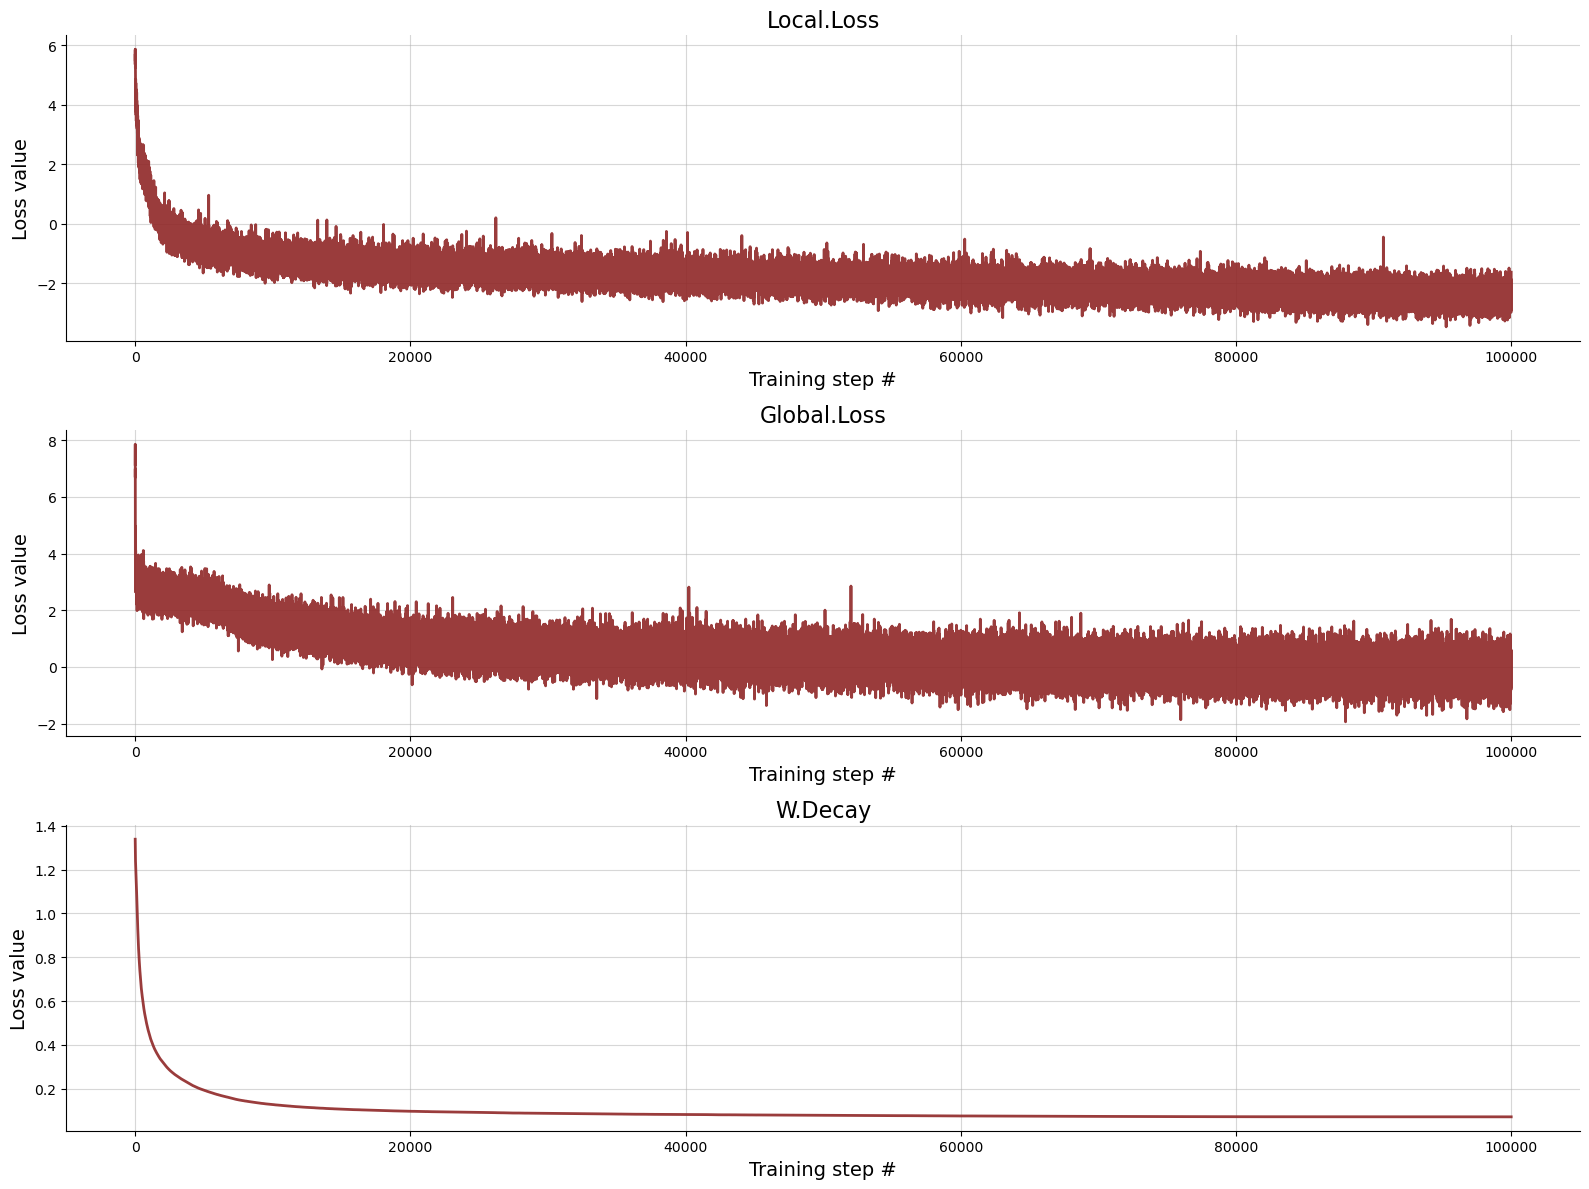

In [7]:
f = beef.diagnostics.plot_losses(history)

### Simulation-based Calibration

In [8]:
import _pickle

In [9]:
if RESIMULATE:
    sim_data = model.generate(batch_size=NUM_SBC_SIMULATIONS)
    configured_sim_data = model.configure(sim_data) 
        
    sbc_data = configured_sim_data['summary_conditions']
    sbc_global_posteriors_z = np.zeros((NUM_SBC_SIMULATIONS, NUM_SBC_POST_SAMPLES, 6))
    sbc_local_posteriors_z = np.zeros((NUM_SBC_SIMULATIONS, NUM_OBS, NUM_SBC_POST_SAMPLES, 4)) 

    # separate handling for each data set
    for i in tqdm(range(NUM_SBC_SIMULATIONS)):
        sbc_posterior_samples = experiment.amortizer.sample(
            {'summary_conditions': sbc_data[i:i+1]},
            n_samples=NUM_SBC_POST_SAMPLES,
        )
        sbc_global_posteriors_z[i] = sbc_posterior_samples['global_samples'] # 6 parameters: 4 hyper, 2 shared
        sbc_local_posteriors_z[i] = sbc_posterior_samples['local_samples']
    with open("../data/sim_data.txt", "wb") as myFile:
        _pickle.dump(sim_data, myFile)
    with open("../data/sbc_posterior_samples.txt", "wb") as myFile:
        _pickle.dump(sbc_posterior_samples, myFile)
    with open("../data/sbc_global_posteriors_z.txt", "wb") as myFile:
        _pickle.dump(sbc_global_posteriors_z, myFile)
    with open("../data/sbc_local_posteriors_z.txt", "wb") as myFile:
        _pickle.dump(sbc_local_posteriors_z, myFile)
else:
    with open("../data/sim_data.txt", "rb") as myFile:
        sim_data = _pickle.load(myFile)
    with open("../data/sbc_posterior_samples.txt", "rb") as myFile:
        sbc_posterior_samples = _pickle.load(myFile)
    with open("../data/sbc_global_posteriors_z.txt", "rb") as myFile:
        sbc_global_posteriors_z = _pickle.load(myFile)
    with open("../data/sbc_local_posteriors_z.txt", "rb") as myFile:
        sbc_local_posteriors_z = _pickle.load(myFile)

In [10]:
true_hyper_params = sim_data['hyper_prior_draws']
true_local_params = sim_data['local_prior_draws']
true_shared_params = sim_data['shared_prior_draws']

In [11]:
local_params = sbc_local_posteriors_z * model.local_prior_stds + model.local_prior_means
hyper_params = sbc_global_posteriors_z[:, :, 0:4] * model.hyper_prior_std + model.hyper_prior_mean
shared_params = sbc_global_posteriors_z[:, :, 4:]

#### Calibration of Global Parameters

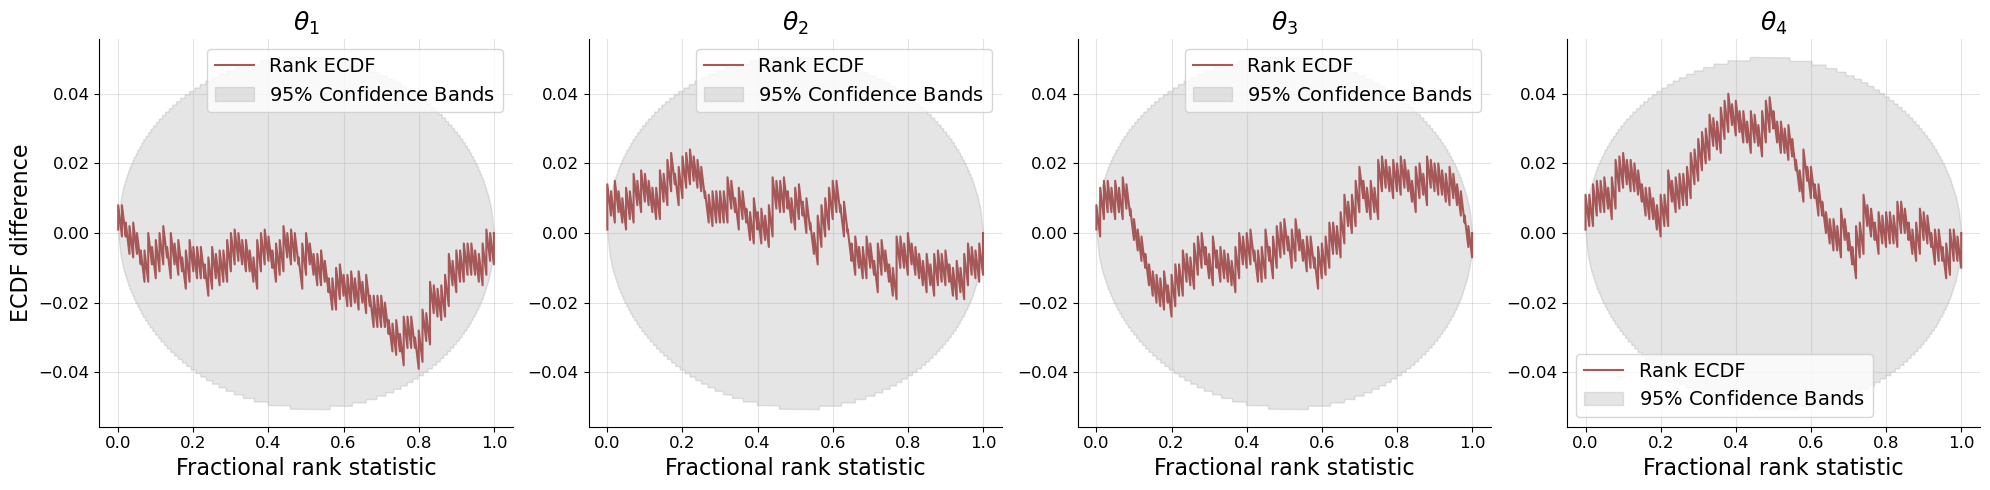

In [12]:
f = beef.diagnostics.plot_sbc_ecdf(
        hyper_params,
        true_hyper_params,
        difference=True 
    )
plt.savefig("../plots/sbc_ecdf_hyper.png")

#### Calibration of Shared Parameters

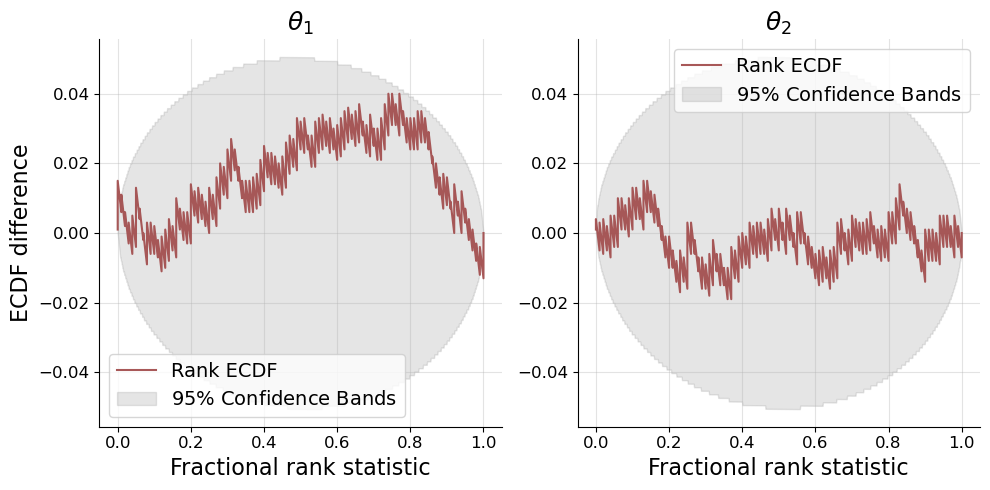

In [13]:
f = beef.diagnostics.plot_sbc_ecdf(
        shared_params,
        true_shared_params,
        difference=True 
    )
plt.savefig("../plots/sbc_ecdf_shared.png")

#### Calibration of Local Parameters

In [14]:
RESIMULATE = False
if RESIMULATE:
    local_calibration_error = np.zeros((NUM_OBS, 4))
    for i in tqdm(range(NUM_OBS)):
        local_calibration_error[i] = beef.computational_utilities.posterior_calibration_error(
            local_params[:, i],
            true_local_params[:, i]
        )
    with open("../data/local_calibration_error.txt", "wb") as myFile:
        _pickle.dump(local_calibration_error, myFile)
else:
    with open("../data/local_calibration_error.txt", "rb") as myFile:
        local_calibration_error = _pickle.load(myFile)

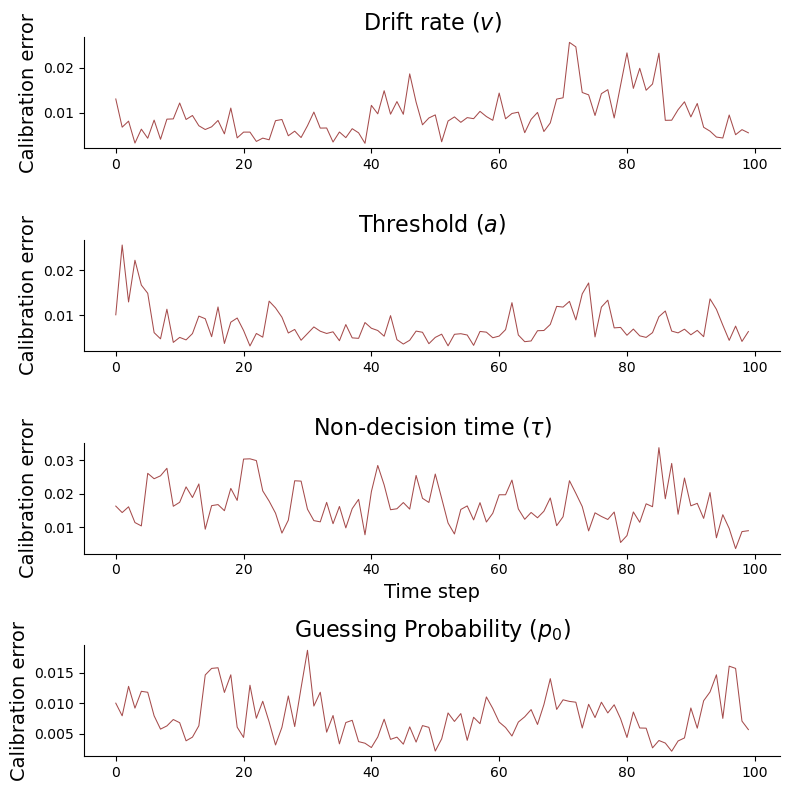

In [15]:
f, axarr = plt.subplots(4, 1, figsize=(8, 8))
for i, ax in enumerate(axarr.flat):
    ax.plot(
        local_calibration_error[:, i],
        linewidth=0.75, color='maroon', alpha=0.7
    )
    ax.set_title(f'{LOCAL_PARAM_LABELS[i]} (${LOCAL_PARAM_NAMES[i]}$)', fontsize=16)
    ax.set_ylabel("Calibration error", fontsize=14)
    if i == 2:
        ax.set_xlabel("Time step", fontsize=14)
sns.despine()
f.tight_layout()
plt.savefig("../plots/local_calibration_error.png")

### Parameter Recovery

#### Parameter Recovery of Local Parameters

In [16]:
validation_sim = model.generate(1)
post_samples = experiment.amortizer.sample(model.configure(validation_sim), 1000)

In [17]:
local_post = post_samples['local_samples'] * model.local_prior_stds + model.local_prior_means
true_params = validation_sim['local_prior_draws'][0]
post_median = np.median(local_post, axis=1)
post_mad = median_abs_deviation(local_post, axis=1)

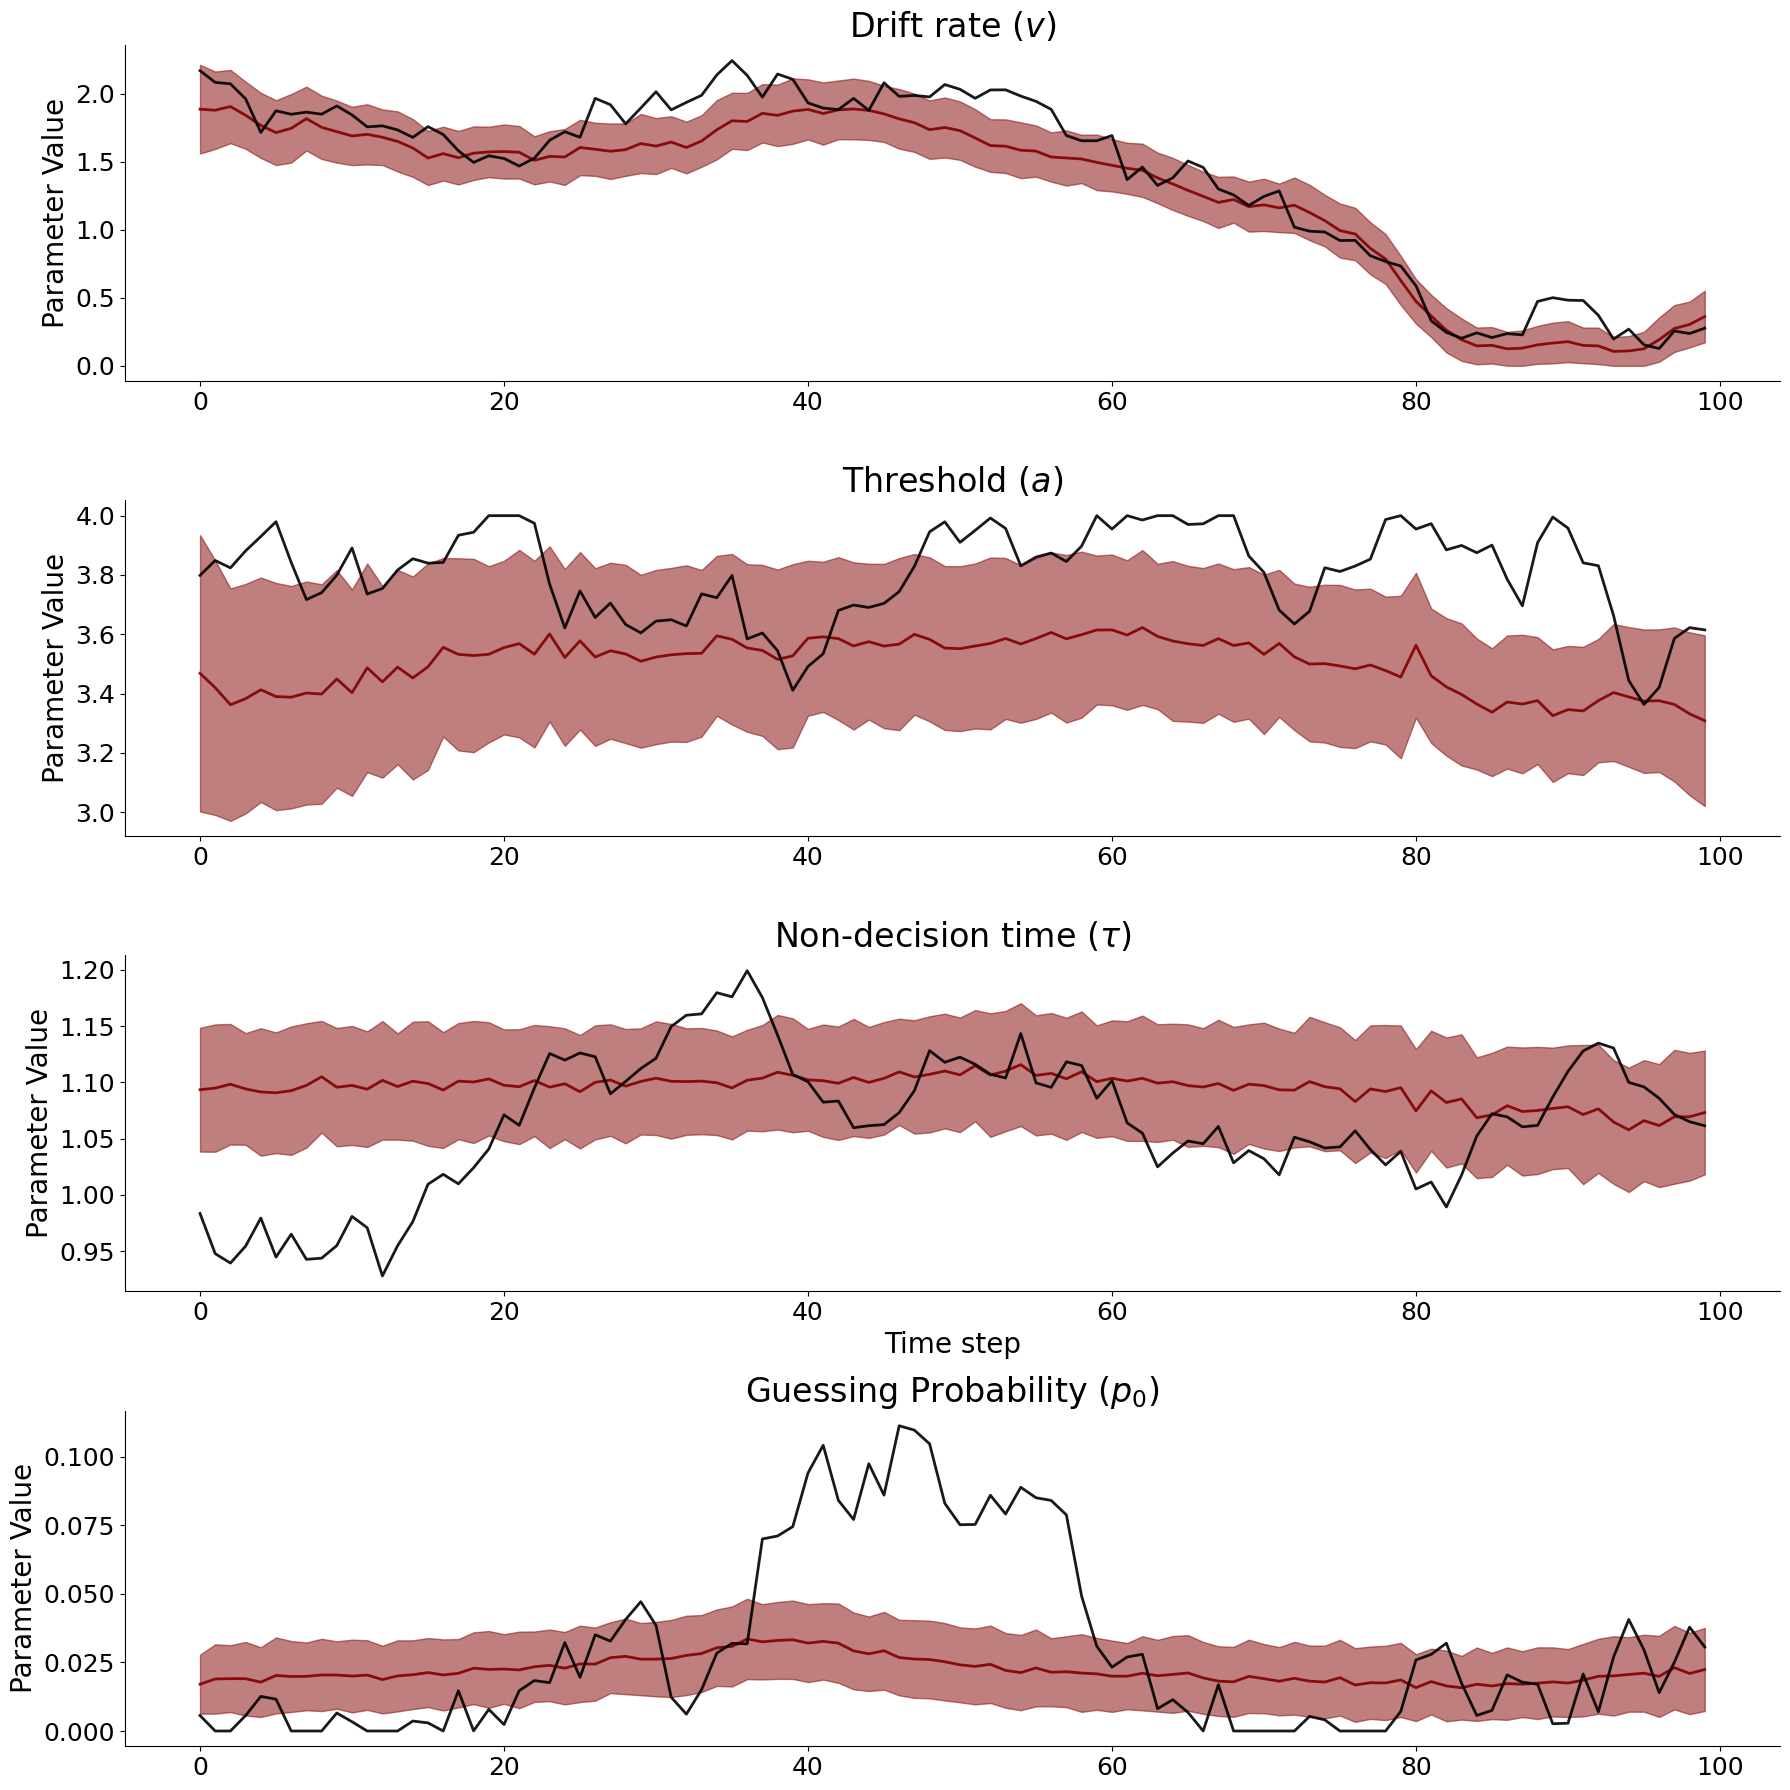

In [18]:
fig, axarr = plt.subplots(4, 1, figsize=(18, 18))
for i, ax in enumerate(axarr.flat):
    # parameter trajectory
    ax.plot(
        range(NUM_OBS),
        post_median[:, i], 
        color='maroon', alpha=0.9, lw=2, label="Posterior median"
        )
    ax.fill_between(
        range(NUM_OBS),
        post_median[:, i] - post_mad[:, i],
        post_median[:, i] + post_mad[:, i],
        color='maroon', alpha=0.5, label="Posterior MAD"
        )
    ax.plot(
        range(NUM_OBS),
        true_params[:, i], 
        color='black', alpha=0.9, lw=2, label="Ground truth"
        )
    ax.set_title(f'{LOCAL_PARAM_LABELS[i]} (${LOCAL_PARAM_NAMES[i]}$)', fontsize=24)
    ax.set_ylabel("Parameter Value", fontsize=20)
    if i == 2:
        ax.set_xlabel("Time step", fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=18)

sns.despine()
fig.tight_layout()
plt.savefig("../plots/local_param_recovery.png")

#### Local Parameter Recovery at Specific Timepoints

In [19]:
TIME_POINTS = np.array([10, 25, 75, 100]) - 1
param_names = [
    r'Drift rate ($v$)', r'Threshold ($a$)',
    r'Non-decision time ($\tau$)', r'Probability to Guess ($\p_0$)'
]

In [20]:
# sim_data = model.generate(batch_size=NUM_SIM)
# configured_sim_data = model.configure(sim_data) 
# true_hyper_params = sim_data['hyper_prior_draws']
# true_local_params = sim_data['local_prior_draws']
# true_shared_params = sim_data['shared_prior_draws']

In [21]:
if RESIMULATE:
    sim_data_v2 = model.generate(batch_size=NUM_SIM)
    configured_sim_data = model.configure(sim_data_v2) 
    
    val_data = configured_sim_data['summary_conditions']
    global_posteriors_z = np.zeros((NUM_SIM, NUM_SAMPLES, 6))
    local_posteriors_z = np.zeros((NUM_SIM, NUM_OBS, NUM_SAMPLES, 4)) 

    # separate handling for each data set
    for i in tqdm(range(NUM_SIM)):
        posterior_samples = experiment.amortizer.sample(
            {'summary_conditions': val_data[i:i+1]},
            n_samples=NUM_SAMPLES,
        )
        global_posteriors_z[i] = posterior_samples['global_samples'] # 6 parameters: 4 hyper, 2 shared
        local_posteriors_z[i] = posterior_samples['local_samples']
    with open("../data/sim_data_v2.txt", "wb") as myFile:
        _pickle.dump(sim_data_v2, myFile)
    with open("../data/posterior_samples.txt", "wb") as myFile:
        _pickle.dump(posterior_samples, myFile)
    with open("../data/global_posteriors_z.txt", "wb") as myFile:
        _pickle.dump(global_posteriors_z, myFile)
    with open("../data/local_posteriors_z.txt", "wb") as myFile:
        _pickle.dump(local_posteriors_z, myFile)
else:
    with open("../data/sim_data_v2.txt", "rb") as myFile:
        sim_data_v2 = _pickle.load(myFile)
    with open("../data/posterior_samples.txt", "rb") as myFile:
        posterior_samples = _pickle.load(myFile)
    with open("../data/global_posteriors_z.txt", "rb") as myFile:
        global_posteriors_z = _pickle.load(myFile)
    with open("../data/local_posteriors_z.txt", "rb") as myFile:
        local_posteriors_z = _pickle.load(myFile)

In [22]:
true_hyper_params = sim_data_v2['hyper_prior_draws']
true_local_params = sim_data_v2['local_prior_draws']
true_shared_params = sim_data_v2['shared_prior_draws']

In [23]:
local_params = local_posteriors_z * model.local_prior_stds + model.local_prior_means
hyper_params = global_posteriors_z[:, :, 0:4] * model.hyper_prior_std + model.hyper_prior_mean
shared_params = global_posteriors_z[:, :, 4:]

In [25]:
post_median = np.median(local_params, axis=2)

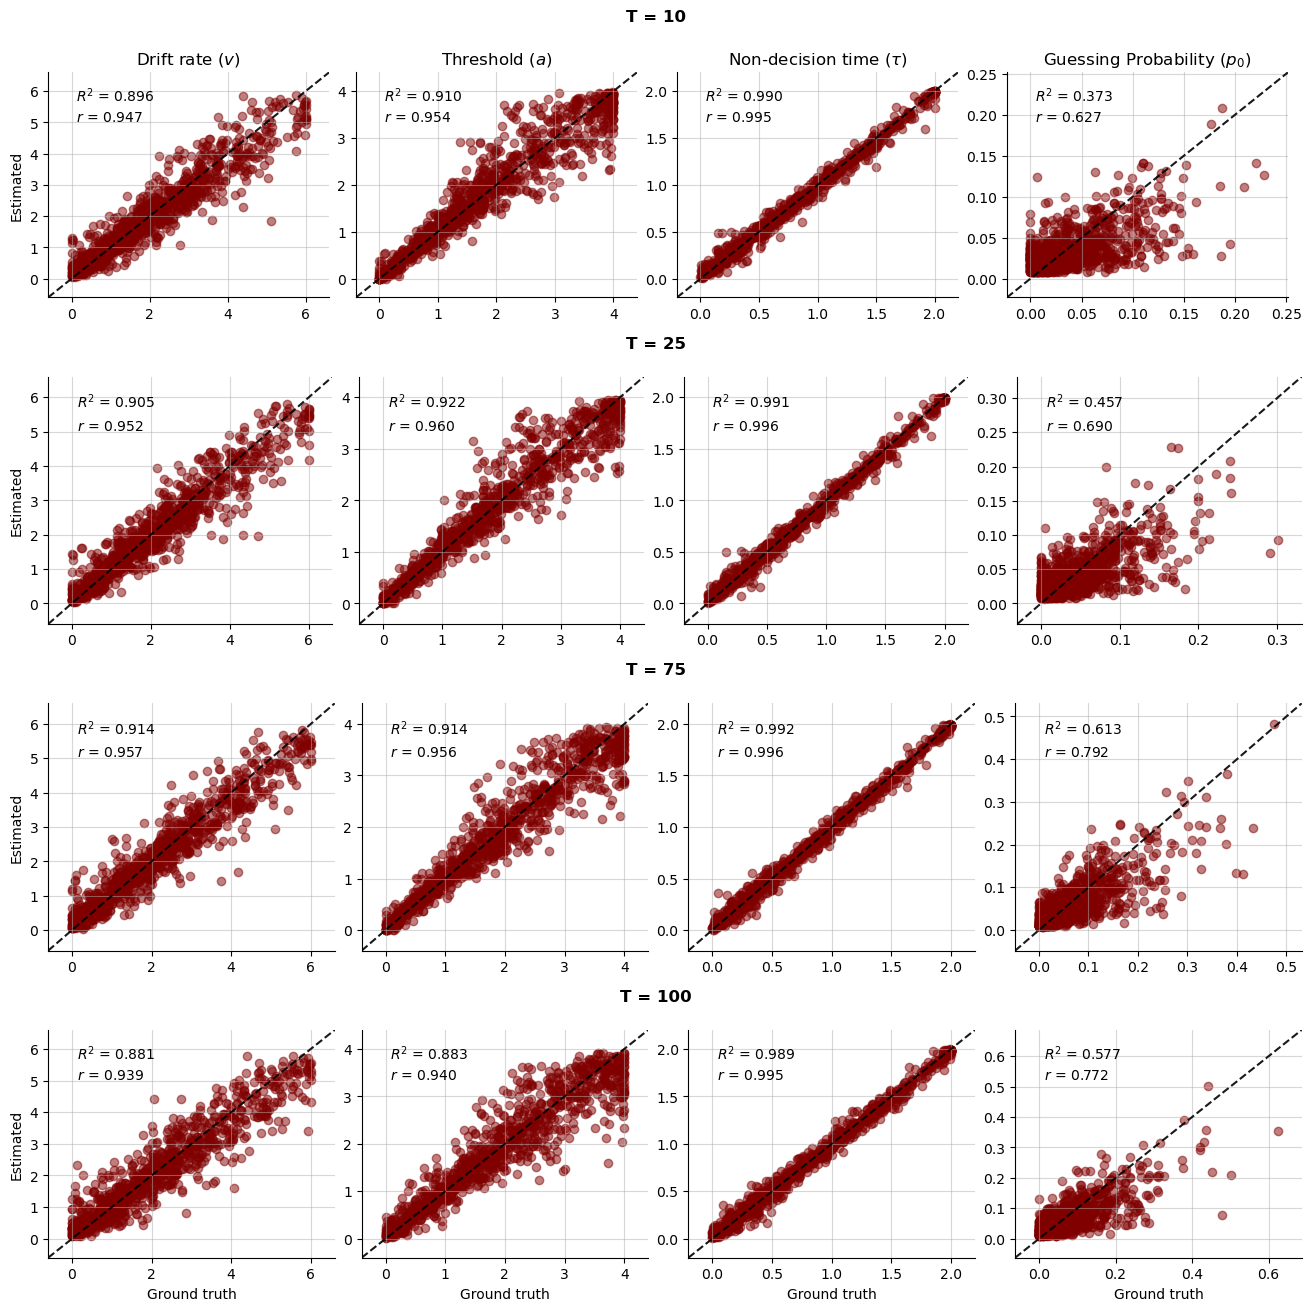

In [26]:
which_time_point = np.repeat(np.arange(4), 4)
which_param = np.tile(np.arange(4), 4)
fig = plt.figure(constrained_layout=True, figsize=(13, 13))
subfigs = fig.subfigures(nrows=4, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(
        "T = {}\n".format(TIME_POINTS[row] + 1),
        fontweight='semibold'
    )
    axs = subfig.subplots(nrows=1, ncols=4)
    for col, ax in enumerate(axs):
        ax.scatter(
            true_local_params[:, TIME_POINTS[row], col],
            post_median[:, TIME_POINTS[row], col],
            alpha=0.5, color="maroon"
        )
        lower = min(
            true_local_params[:, TIME_POINTS[row], col].min(),
            post_median[:, TIME_POINTS[row], col].min()
        )
        upper = max(
            true_local_params[:, TIME_POINTS[row], col].max(),
            post_median[:, TIME_POINTS[row], col].max()
        )
        eps = (upper - lower) * 0.1
        ax.set_xlim([lower - eps, upper + eps])
        ax.set_ylim([lower - eps, upper + eps])
        ax.plot(
            [ax.get_xlim()[0], ax.get_xlim()[1]],
            [ax.get_ylim()[0], ax.get_ylim()[1]],
            color="black",
            alpha=0.9,
            linestyle="dashed",
        )

        r2 = r2_score(
            true_local_params[:, TIME_POINTS[row], col],
            post_median[:, TIME_POINTS[row], col]
        )
        ax.text(
            0.1, 0.9,
            "$R^2$ = {:.3f}".format(r2),
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes
        )
        corr = np.corrcoef(
            true_local_params[:, TIME_POINTS[row], col],
            post_median[:, TIME_POINTS[row], col]
        )[0, 1]
        ax.text(
            0.1, 0.8,
            "$r$ = {:.3f}".format(corr),
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
        )
        if row == 0:
            ax.set_title(f'{LOCAL_PARAM_LABELS[col]} (${LOCAL_PARAM_NAMES[col]}$)')
        if row == 3:
            ax.set_xlabel("Ground truth")
        if col == 0:
            ax.set_ylabel("Estimated")
        # Prettify
        ax.grid(alpha=0.5)
        ax.tick_params(axis="both", which="major")
        ax.tick_params(axis="both", which="minor")
    sns.despine()
plt.savefig("../plots/local_param_recovery_timepoints.png")

#### Parameter Recovery of Hyper Parameters

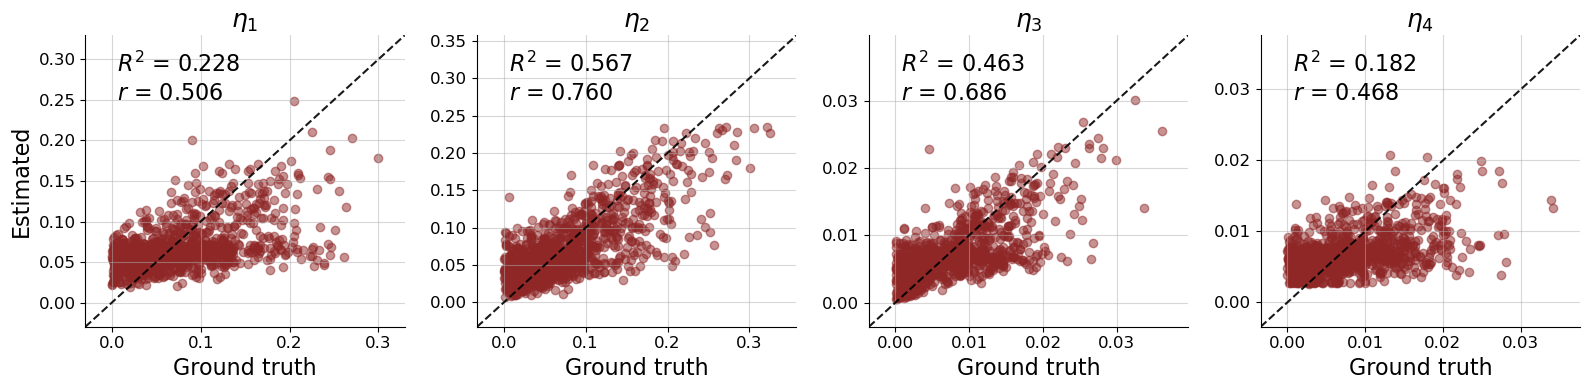

In [27]:
f = beef.diagnostics.plot_recovery(
    hyper_params,
    true_hyper_params,
    uncertainty_agg=None,
    param_names=HYPER_PARAM_NAMES
)
plt.savefig("../plots/hyper_param_recovery.png")

#### Parameter Recovery of Shared Parameters

In [28]:
configured_sim_data = model.configure(sim_data) 

In [29]:
prior_shared_samples = configured_sim_data["shared_parameters"]

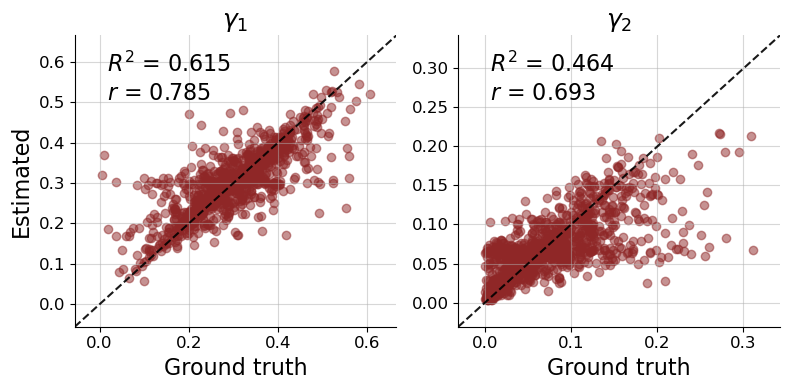

In [30]:
f = beef.diagnostics.plot_recovery(
    shared_params,
    true_shared_params,
    uncertainty_agg=None,
    param_names=SHARED_PARAM_NAMES
)
plt.savefig("../plots/shared_param_recovery.png")

### Prior Pushforward Check

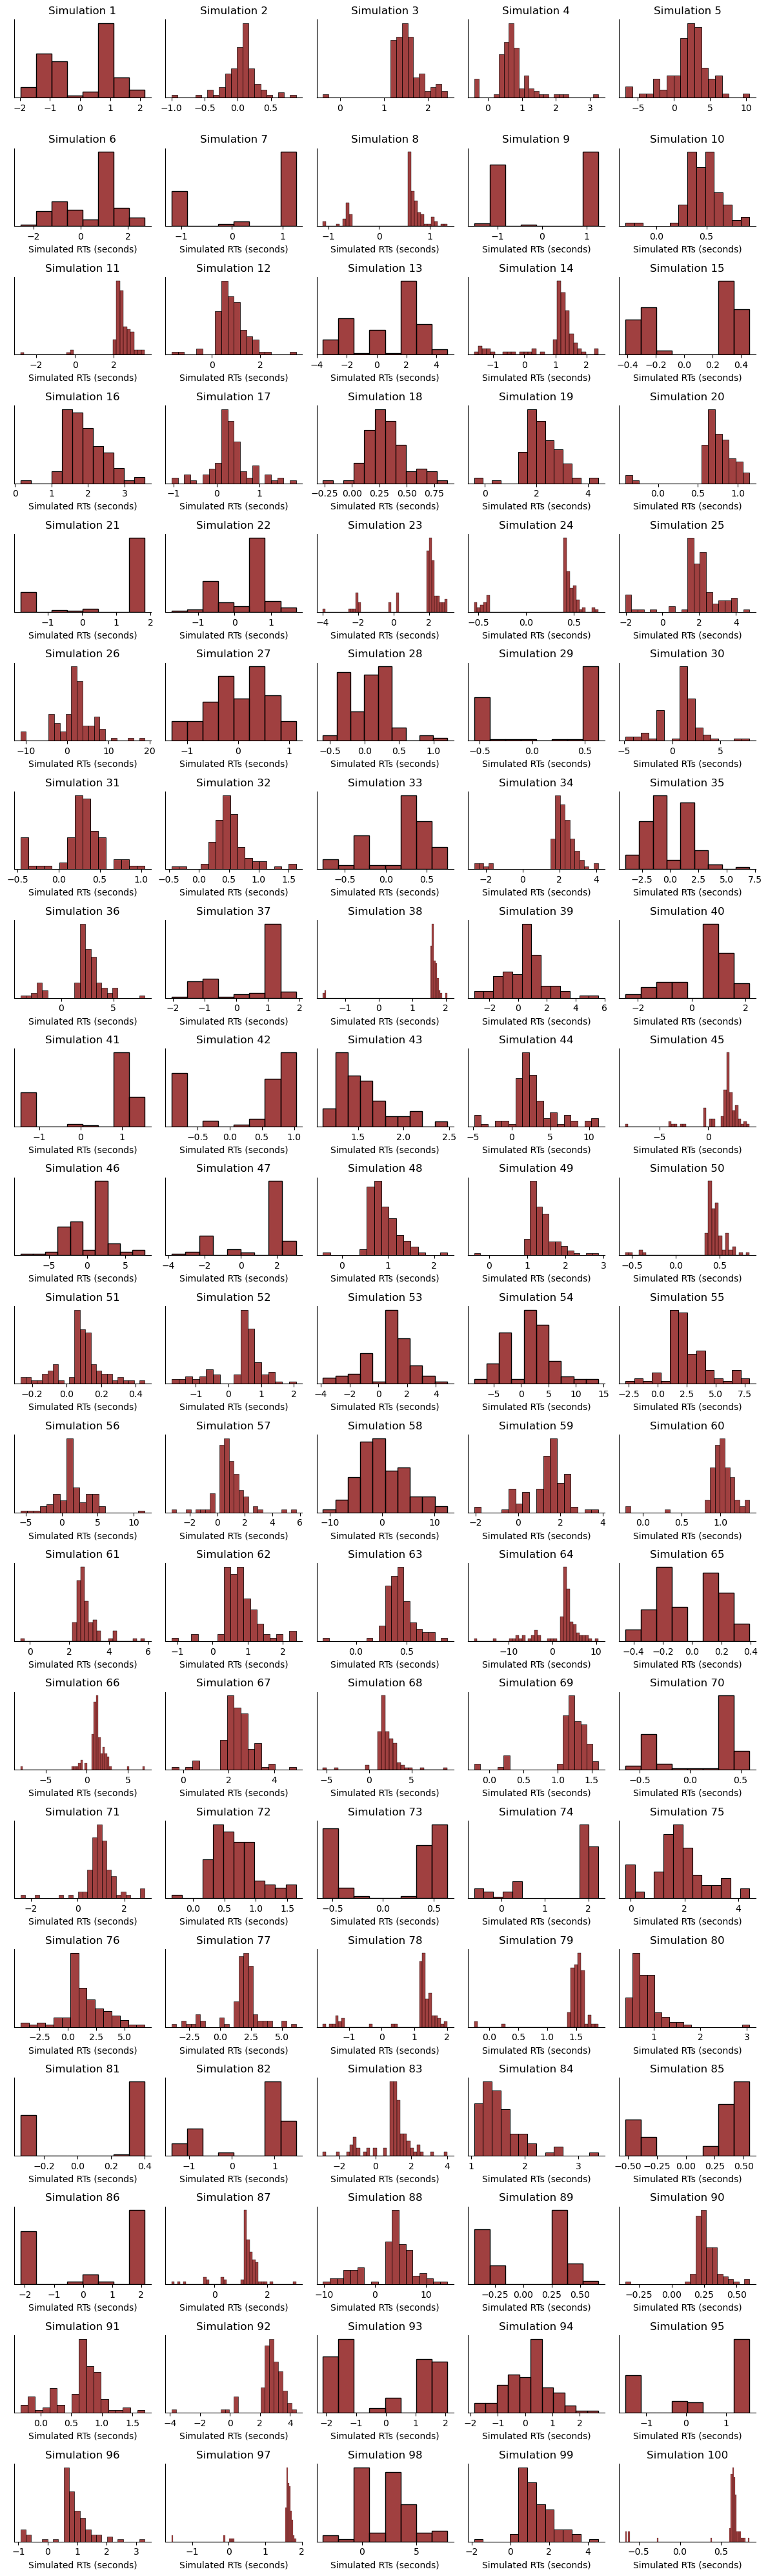

In [30]:
f, axarr = plt.subplots(20, 5, figsize=(12, 40))
for i, ax in enumerate(axarr.flat):
    sns.histplot(sim_data["sim_data"][i, :].flatten(), color="maroon", alpha=0.75, ax=ax)
    sns.despine(ax=ax)
    ax.set_ylabel("")
    ax.set_yticks([])
    ax.set_title(f"Simulation {i + 1}")
    if i > 4:
        ax.set_xlabel("Simulated RTs (seconds)")
f.tight_layout()

In [31]:
ddm_parameters = sim_data['local_prior_draws'][74]
time_steps = np.arange(ddm_parameters.shape[0])
LOCAL_PARAM_LABELS = ['Drift rate', 'Threshold', 'Non-decision time', 'Probability to Guess']
LOCAL_PARAM_NAMES  = [r'v', r'a', r'\tau', r'p_0']

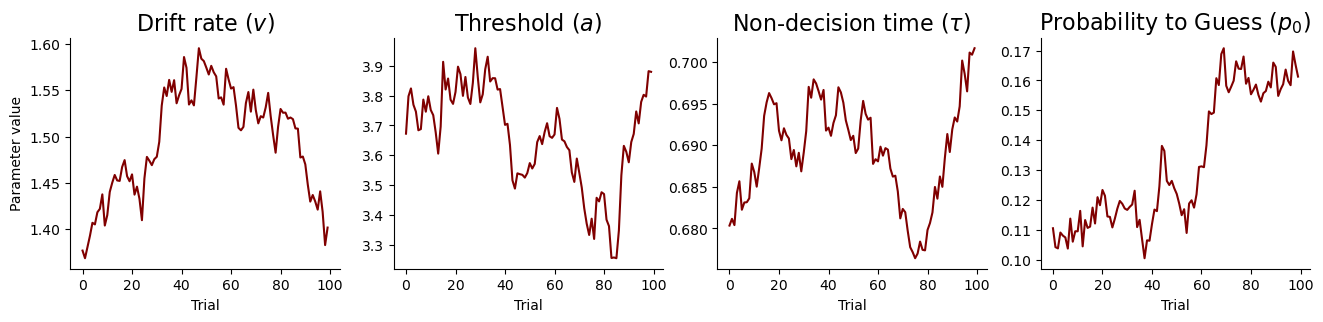

In [32]:
f, axarr = plt.subplots(1, 4, figsize=(16, 3))
for i, ax in enumerate(axarr.flat):
    ax.plot(time_steps, ddm_parameters[:, i], color='maroon')
    ax.set_title(f'{LOCAL_PARAM_LABELS[i]} (${LOCAL_PARAM_NAMES[i]}$)', fontsize=16)
    if i == 0:
        ax.set_ylabel("Parameter value")
    ax.set_xlabel("Trial")
sns.despine()
f.tight_layout
plt.savefig("../plots/exemplary_trajectory_sim.png")

### Prior Predictive Checks

In [ ]:
# we can use the sampled model configuration for prior pushforward checks and the simulated observation 
# for prior predictive checks without any additional cost

In [55]:
N_RESIM = 200
N_OBS = sim_data["sim_data"].shape[1]
N_SIM = 50

In [39]:
# clip all samples of guessing probability to lower bound 0
local_params[:,:,:,0] = np.clip(local_params[:,:,:,0], 0, 6)
local_params[:,:,:,1] = np.clip(local_params[:,:,:,1], 0, 4)
local_params[:,:,:,2] = np.clip(local_params[:,:,:,2], 0, 2)
local_params[:,:,:,3] = np.clip(local_params[:,:,:,3], 0, 1)

In [40]:
shared_params = np.clip(shared_params, 0, 5)

In [56]:
pred_data = np.zeros((N_RESIM, N_SIM, N_OBS, 1))

for s in range(N_SIM):
    post_idx = np.random.choice(np.arange(NUM_SAMPLES), N_RESIM)
    for i in range(N_RESIM):
        idx = post_idx[i]
        pred_data[i, s] = sample_random_walk_mixture_diffusion_process(
            (local_params[s, :, idx, :], shared_params[s, idx, :]))[:, None]

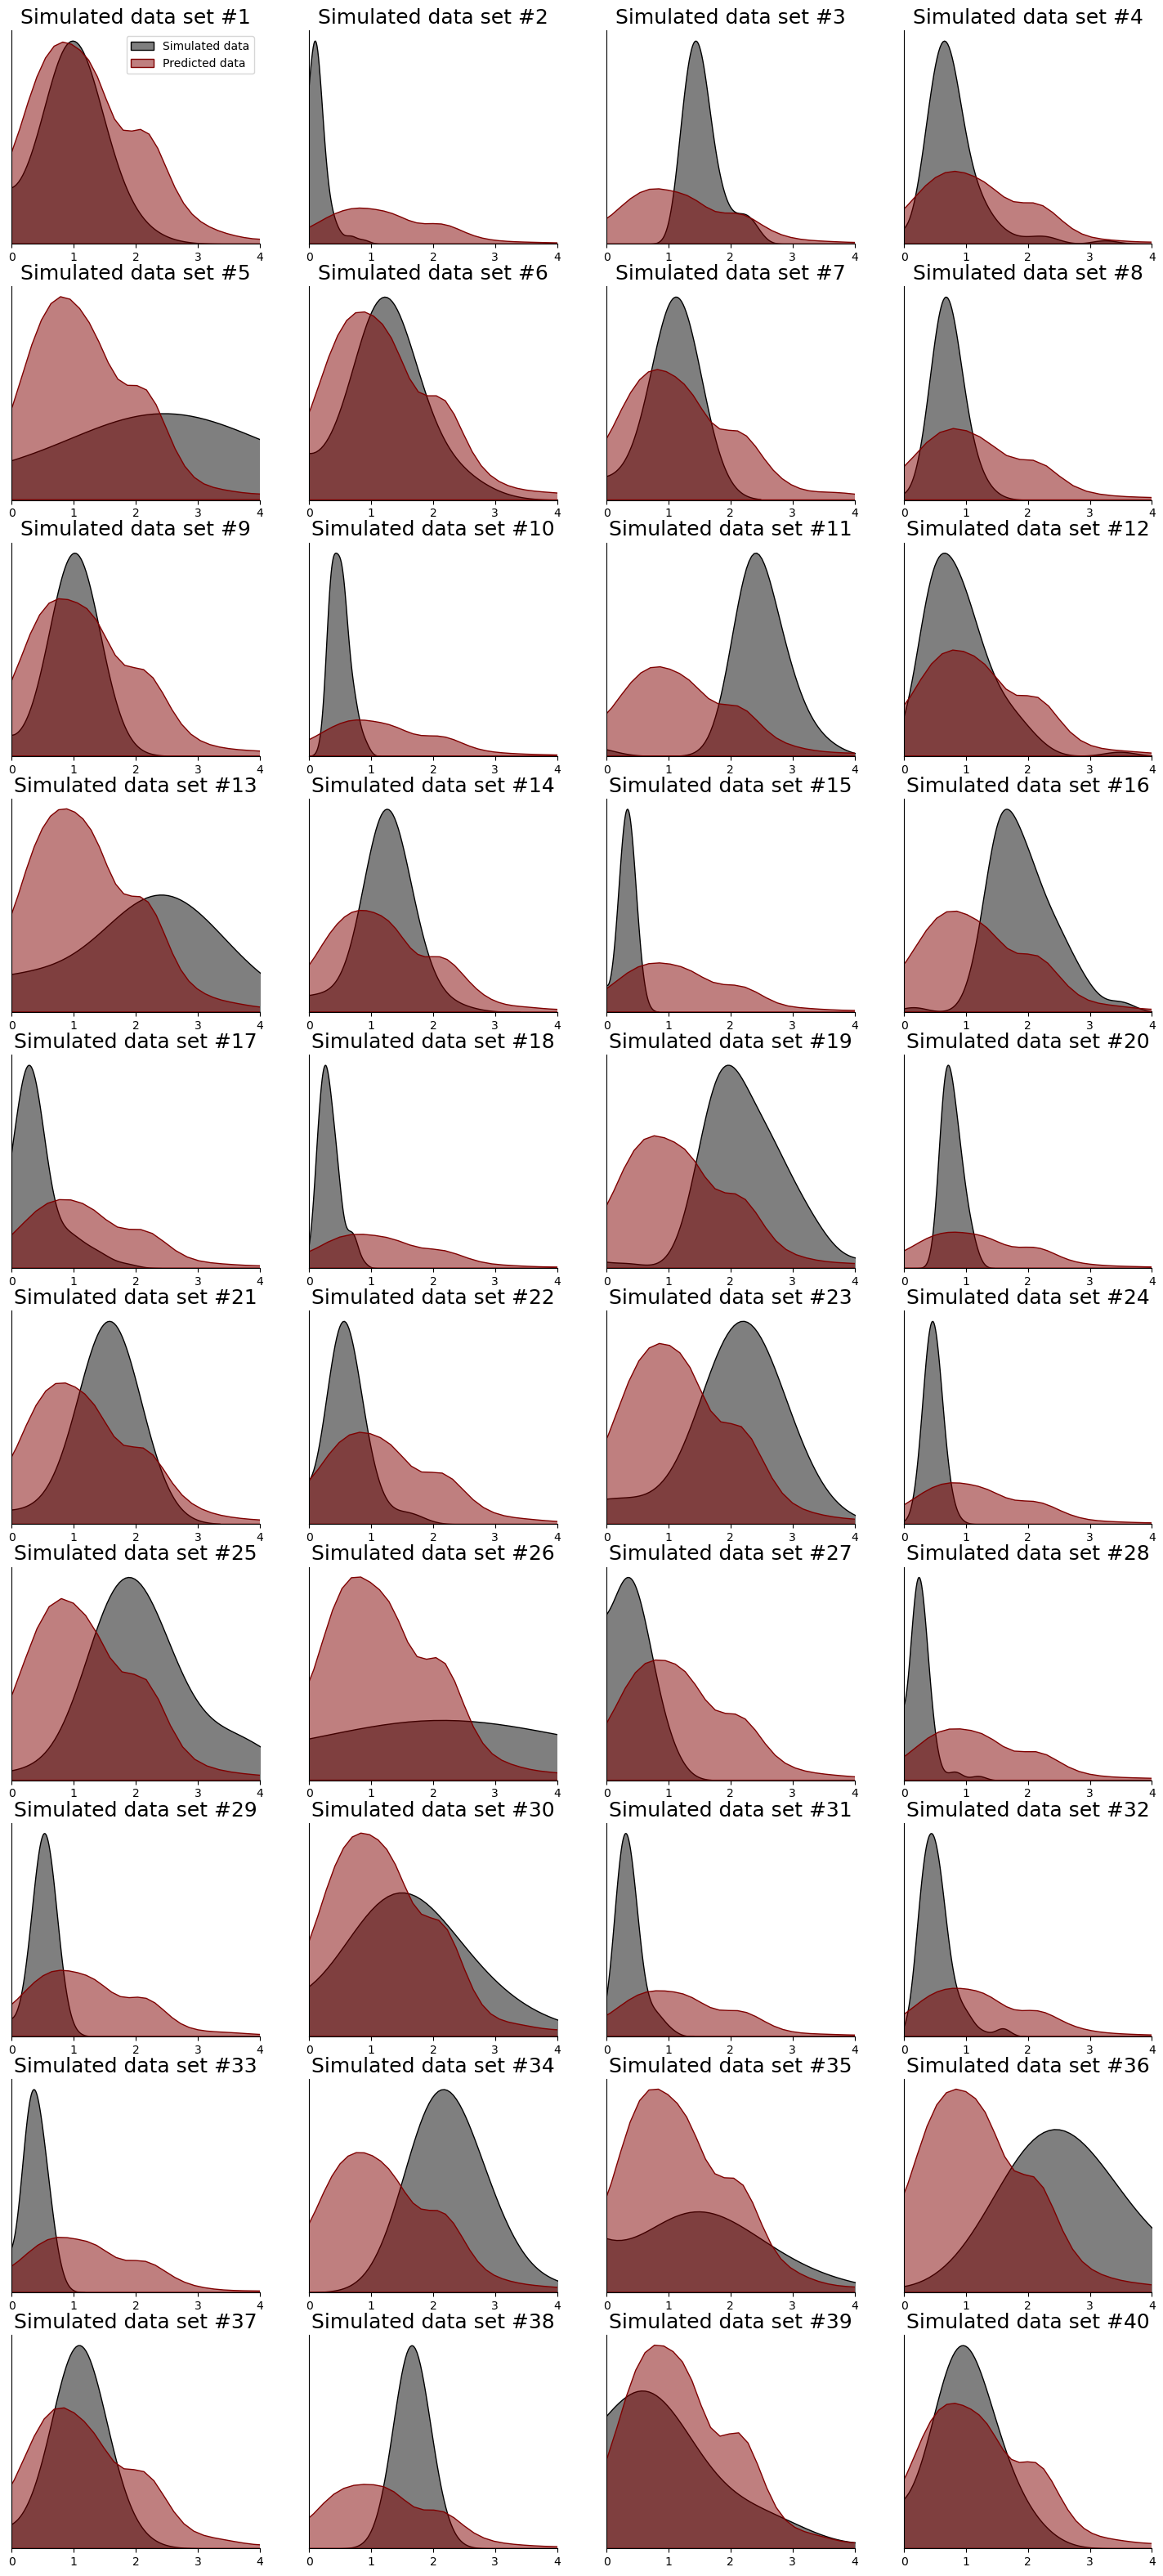

In [61]:
f, axarr = plt.subplots(10, 4, figsize = (18,40))
for i, ax in enumerate(axarr.flat):
    sns.kdeplot(
        configured_sim_data["summary_conditions"][i, :, 0], ax=ax, fill=True, color="black", 
        alpha=0.5, label="Simulated data"
    )
    sns.kdeplot(
        pred_data[i, :, :, 0].flatten(), ax=ax, fill=True, color="maroon",
        alpha=0.5, label="Predicted data")
    ax.set_xlim((0, 4))
    ax.set_ylabel("")
    ax.set_yticks([])
    ax.set_title(f"Simulated data set #{i+1}", fontsize=18)
    # Set legend to first plot
    if i == 0:
        ax.legend()

    # Set x label to bottom row
    if i > (N_RESIM // 2) - 1:
        ax.set_xlabel("Response time (seconds)", fontsize=16)
    sns.despine()

In [ ]:
# looks a bit shitty right now
# what numeric indicators do I use here?

## Evaluation

### Schnuerch 2014

In [95]:
data = pd.read_csv("../data/2afc_data.csv")
data["rt"][data["correct"] == 0] = -data["rt"][data["correct"] == 0]

C:\Users\selin\AppData\Local\Temp\ipykernel_28792\3704326702.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["rt"][data["correct"] == 0] = -data["rt"][data["correct"] == 0]


In [127]:
N_OBS = 80
N_SUB = len(np.unique(data['id']))
N_SAMPLES = 2000
N_RESIM = 200

LOCAL_PARAM_LABELS = ['Drift rate', 'Threshold', 'Non-decision time', 'Guessing Probability']
LOCAL_PARAM_NAMES  = [r'v', r'a', r'\tau', r'p_0']

FONT_SIZE_1 = 18
FONT_SIZE_2 = 16
FONT_SIZE_3 = 12

import matplotlib
# matplotlib.rcParams['font.sans-serif'] = "Palatino"
# matplotlib.rcParams['font.family'] = "sans-serif"

In [99]:
FIT_MODEL = True

if FIT_MODEL:
    post_samples = np.zeros((N_SUB, N_OBS, N_SAMPLES, 4))
    padding = np.full((1, N_SAMPLES, 4), np.nan)
    with tf.device('/cpu:0'):
        for i in tqdm(range(N_SUB)):
            person_data = data[data['id'] == i+1]
            person_data = person_data['rt'].to_numpy()
            nan_idx = np.argwhere(np.isnan(person_data))
            tmp_data = person_data[np.isfinite(person_data)]
            tmp_data = {'summary_conditions': tmp_data[None, ..., None]}
            samples = experiment.amortizer.sample(tmp_data, N_SAMPLES)['local_samples']
            for idx in range(nan_idx.shape[0]):
                start_idx = nan_idx[idx][0]
                samples = np.concatenate(
                    (samples[:start_idx, :, :], padding, samples[start_idx:, :, :]), axis=0
                )
            post_samples[i] = samples
    np.save("../data/data_post_samples.npy", post_samples)
else:
    post_samples = np.load("../data/data_post_samples.npy")

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [09:20<00:00, 17.52s/it]


In [102]:
data_local_samples_not_z = post_samples * model.local_prior_stds + model.local_prior_means
post_means = np.nanmean(data_local_samples_not_z, axis=2) # parameter estimates for each subject for each trial
post_means_mean = np.nanmean(post_means, axis=0) # means of the 4 dynamic parameters for each trial across subjects
post_means_std = np.nanstd(post_means, axis=0)

C:\Users\selin\AppData\Local\Temp\ipykernel_28792\697473869.py:2: RuntimeWarning: Mean of empty slice
  post_means = np.nanmean(data_local_samples_not_z, axis=2)


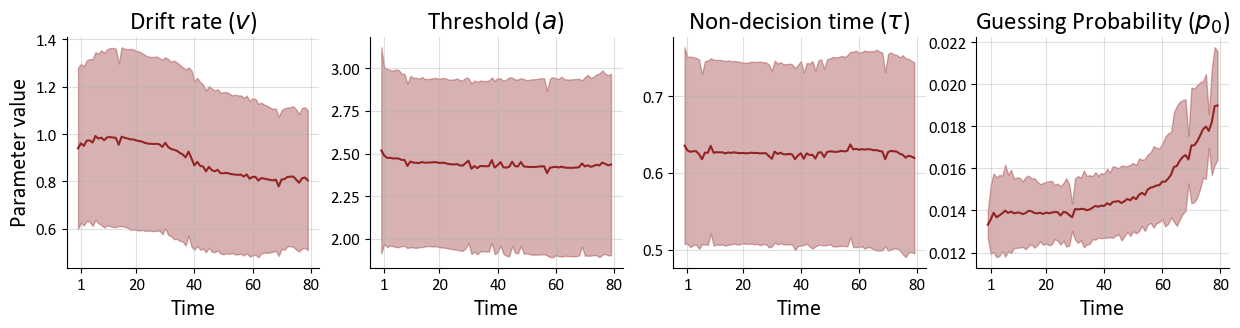

In [128]:
fig, axarr = plt.subplots(1, 4, figsize=(15, 3))
for i, ax in enumerate(axarr.flat):
    ax.plot(
        range(N_OBS), post_means_mean[:, i],
        color='maroon', alpha=0.8
    )
    ax.fill_between(
        range(N_OBS),
        post_means_mean[:, i] - post_means_std[:, i],
        post_means_mean[:, i] + post_means_std[:, i],
        color='maroon', alpha=0.3
    )
    ax.set_title(f'{LOCAL_PARAM_LABELS[i]} (${LOCAL_PARAM_NAMES[i]}$)', fontsize=FONT_SIZE_1)
    ax.grid(alpha=0.4)

    if i == 0:
        ax.set_ylabel("Parameter value", fontsize=FONT_SIZE_2)
    ax.set_xlabel("Time", fontsize=FONT_SIZE_2)
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    ax.set_xticks([1, 20, 40, 60, 80])

sns.despine()
f.tight_layout()

plt.savefig('../plots/parameter_dynamic_2afc.png', dpi=300)

In [126]:
tmp = post_means.reshape(N_SUB*N_OBS, 4) 
dataframe = pd.DataFrame(tmp) 
dataframe.to_csv("..\data\post_means_schnuerch.csv")

### Criss 2017

In [204]:
criss = pd.read_csv("../data/criss-2017.csv")
criss["rt"][criss["correct"] == 0] = -criss["rt"][criss["correct"] == 0]

C:\Users\selin\AppData\Local\Temp\ipykernel_28792\113189377.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  criss["rt"][criss["correct"] == 0] = -criss["rt"][criss["correct"] == 0]


In [205]:
N_OBS = 100
N_SUB = len(np.unique(criss['sub']))
N_SAMPLES = 2000
N_RESIM = 200

In [212]:
if FIT_MODEL:
    post_samples_criss = np.zeros((N_SUB, N_OBS, N_SAMPLES, 4))
    padding = np.full((1, N_SAMPLES, 4), np.nan)
    with tf.device('/cpu:0'):
        for i in tqdm(range(N_SUB)):
            person_data = criss[criss['sub'] == i+1] # select data for one person
            person_data = person_data['rt'].to_numpy() # select rts of that person
            nan_idx = np.argwhere(np.isnan(person_data)) # 
            tmp_data = person_data[np.isfinite(person_data)]
            tmp_data = {'summary_conditions': tmp_data[None, ..., None]} # make dictionary (rt = summary consitions)
            samples = experiment.amortizer.sample(tmp_data, N_SAMPLES)['local_samples'] # select local samples
            for idx in range(nan_idx.shape[0]):
                start_idx = nan_idx[idx][0]
                samples = np.concatenate(
                    (samples[:start_idx, :, :], padding, samples[start_idx:, :, :]), axis=0
                )
            post_samples_criss[i] = samples
    np.save("../data/criss_post_samples.npy", post_samples_criss)
else:
    post_samples_criss = np.load("../data/criss_post_samples.npy")

100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [28:59<00:00, 18.70s/it]


In [213]:
criss_local_samples_not_z = post_samples_criss * model.local_prior_stds + model.local_prior_means
post_means_criss = np.nanmean(criss_local_samples_not_z, axis=2)
post_means_mean_criss = np.nanmean(post_means_criss, axis=0)
post_means_std_criss = np.nanstd(post_means_criss, axis=0)

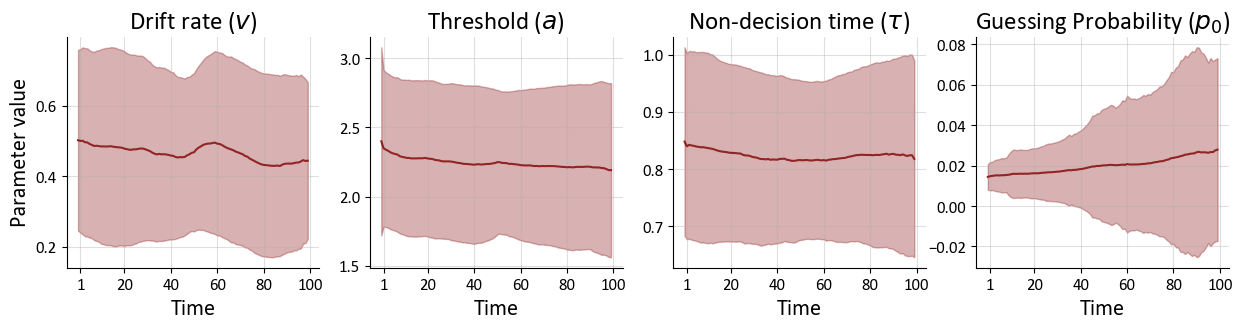

In [216]:
fig, axarr = plt.subplots(1, 4, figsize=(15, 3))
for i, ax in enumerate(axarr.flat):
    ax.plot(
        range(N_OBS), post_means_mean_criss[:, i],
        color='maroon', alpha=0.8
    )
    ax.fill_between(
        range(N_OBS),
        post_means_mean_criss[:, i] - post_means_std_criss[:, i],
        post_means_mean_criss[:, i] + post_means_std_criss[:, i],
        color='maroon', alpha=0.3
    )
    ax.set_title(f'{LOCAL_PARAM_LABELS[i]} (${LOCAL_PARAM_NAMES[i]}$)', fontsize=FONT_SIZE_1)
    ax.grid(alpha=0.4)

    if i == 0:
        ax.set_ylabel("Parameter value", fontsize=FONT_SIZE_2)
    ax.set_xlabel("Time", fontsize=FONT_SIZE_2)
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    ax.set_xticks([1, 20, 40, 60, 80, 100])

sns.despine()
f.tight_layout()

plt.savefig('../plots/parameter_dynamic_2afc_criss.png', dpi=300)

In [215]:
tmp = post_means_criss.reshape(N_SUB*N_OBS, 4) 
dataframe = pd.DataFrame(tmp) 
dataframe.to_csv("..\data\post_means_criss.csv")

## Posterior resimulation

In [ ]:
if POSTERIOR_RESIMULATION:
    pred_data = np.zeros((N_RESIM, N_SUB, N_OBS, 1))
    for s in range(N_SUB):
        post_idx = np.random.choice(np.arange(N_SAMPLES), N_RESIM)
        for i in range(N_RESIM):
            idx = post_idx[i]
            pred_data[i, s] = sample_random_walk_mixture_diffusion_process(
                post_samples_not_z[s, :, idx])[:, None]
    np.save("../data/posterior_resimulation_hehe_hetero.npy", pred_data)
else:
    pred_data = np.load("../data/posterior_resimulation_hehe_hetero.npy")